In [1]:
from math import cos, pi, sin

from direct.showbase.ShowBase import ShowBase
from py_src.util.app import ContextShowBase
from direct.task import Task
from panda3d.core import (
    Geom,
    GeomNode,
    GeomTriangles,
    GeomVertexData,
    GeomVertexFormat,
    GeomVertexWriter,
    GeomEnums
)
# Declare the format of the vertex
# (what and how data will be stored in the vertex buffer)
# https://docs.panda3d.org/1.10/python/programming/internal-structures/procedural-generation/custom-vertex-format
# https://docs.panda3d.org/1.10/python/programming/internal-structures/procedural-generation/predefined-vertex-formats
format_ = GeomVertexFormat.getV3c4()
format_ = GeomVertexFormat.registerFormat(format_)

In [2]:

def create_cube():
    # Instantiate a vertex buffer
    # https://docs.panda3d.org/1.10/python/programming/internal-structures/procedural-generation/creating-vertex-data
    vdata = GeomVertexData("name", format_, Geom.UHStatic)
    vertex = GeomVertexWriter(vdata, "vertex")
    color = GeomVertexWriter(vdata, "color")

    # Add vertices and colors
    vertex.addData3f(-1, -1, -1)
    color.addData4f(0, 0, 0, 1)

    vertex.addData3f(-1, -1, 1)
    color.addData4f(0, 0, 1, 1)

    vertex.addData3f(-1, 1, -1)
    color.addData4f(0, 1, 0, 1)

    vertex.addData3f(-1, 1, 1)
    color.addData4f(0, 1, 1, 1)

    vertex.addData3f(1, -1, -1)
    color.addData4f(1, 0, 0, 1)

    vertex.addData3f(1, -1, 1)
    color.addData4f(1, 0, 1, 1)

    vertex.addData3f(1, 1, -1)
    color.addData4f(1, 1, 0, 1)

    vertex.addData3f(1, 1, 1)
    color.addData4f(1, 1, 1, 1)

    # Create the triangles (2 per face)
    # https://docs.panda3d.org/1.10/python/programming/internal-structures/procedural-generation/creating-primitives
    # prim = GeomTriangles(Geom.UHStatic)
    prim = GeomTriangles(Geom.UHDynamic)
    prim.addVertices(0, 1, 2)
    prim.addVertices(2, 1, 3)
    prim.addVertices(2, 3, 6)
    prim.addVertices(6, 3, 7)
    prim.addVertices(6, 7, 4)
    prim.addVertices(4, 7, 5)
    prim.addVertices(4, 5, 0)
    prim.addVertices(0, 5, 1)
    prim.addVertices(1, 5, 3)
    prim.addVertices(3, 5, 7)
    prim.addVertices(6, 4, 2)
    prim.addVertices(2, 4, 0)

    geom = Geom(vdata)
    geom.addPrimitive(prim)
    node = GeomNode("node")
    node.addGeom(geom)

    return node

In [27]:
c = create_cube()


In [29]:
list(c.children)

[]

In [30]:
# https://stackoverflow.com/questions/75774821/how-to-create-three-dimensional-geometric-shapes-in-panda3d-in-python

#!/usr/bin/env python3







class MyApp(ShowBase):
    def __init__(self):
        super().__init__()

        cube = create_cube()
        self.render.attachNewNode(cube)

        # Set the camera position
        # https://docs.panda3d.org/1.10/python/introduction/tutorial/controlling-the-camera
        self.taskMgr.add(self.spin_camera_task, "SpinCameraTask")

    def spin_camera_task(self, task):
        angleDegrees = task.time * 60.0
        angleRadians = angleDegrees * (pi / 180.0)
        self.camera.setPos(20 * sin(angleRadians), -20 * cos(angleRadians), 3)
        self.camera.setHpr(angleDegrees, 0, 0)

        return Task.cont


app = MyApp()
app.run()

Known pipe types:
  glxGraphicsPipe
(all display modules loaded.)


Exception: Attempt to spawn multiple ShowBase instances!

In [7]:
tot = 5
idx = -1
idx % tot


4

In [7]:
import numpy as np
import torch

from py_src.util.indexing import loop_bound_idx, tup2cnt

def create_sphere_node(
    name:str,
    lat_res:int,
    lon_res:int,
    scale:float=1,
    geom_type: GeomEnums = Geom.UH_static
) -> GeomNode:
    node = GeomNode("SphNd."+name)
    geom = create_sphere(name, lat_res, lon_res, scale, geom_type)
    node.addGeom(geom)
    return node

def create_sphere(
    name:str,
    lat_res:int,
    lon_res:int,
    scale:float=1,
    geom_type: GeomEnums = Geom.UH_static
) -> Geom:
    assert isinstance(lat_res, int) \
        and lat_res > 0, \
        "lat_res should be postive int, got {}".format(lat_res)
    name_sphere = "Spr.{}".format(name)
    vdata = GeomVertexData(name_sphere, format_, geom_type)
    vertex_writer = GeomVertexWriter(vdata, "vertex")
    vertex_size = (lon_res, lat_res)
    # color = GeomVertexWriter(vdata, "color")
    # vertex: n_lat * n_lon * 3
    axis_coord_theta = torch.arange(0,1,step=1/lon_res) * 2 * np.pi
    axis_coord_phi = torch.arange(0,1,step=1/lat_res) * 2 * np.pi
    vertex_coord_theta = torch.broadcast_to(axis_coord_theta.view(-1, 1), vertex_size)
    vertex_coord_phi = torch.broadcast_to(axis_coord_phi.view(1, -1), vertex_size)
    vertex_coord_r = torch.cos(vertex_coord_phi)
    vertex_coord_z = torch.sin(vertex_coord_phi)
    vertex_coord_x = torch.cos(vertex_coord_theta) * vertex_coord_r
    vertex_coord_y = torch.sin(vertex_coord_theta) * vertex_coord_r
    vertex_coord_xyz = torch.concat([
        vertex_coord_x.unsqueeze(-1),
        vertex_coord_y.unsqueeze(-1),
        vertex_coord_z.unsqueeze(-1)
    ], dim=-1)
    
    # add vertices
    for row in range(lat_res):
        for col in range(lon_res):
            coord = vertex_coord_xyz[row, col]
            vertex_writer.addData3f(
                coord[0], coord[1], coord[2]
            )
    # add triangles
    prim = GeomTriangles(geom_type)
    for row in range(lat_res-1):
        for col in range(lon_res):
            prim.addVertices(
                tup2cnt(vertex_size, row, col-1),
                tup2cnt(vertex_size, row, col),
                tup2cnt(vertex_size, row+1, col-1)
            )
            prim.addVertices(
                tup2cnt(vertex_size, row+1, col-1),
                tup2cnt(vertex_size, row+1, col),
                tup2cnt(vertex_size, row, col)
            )
    geom = Geom(vdata)
    geom.addPrimitive(prim)
    
                
    
    return geom
    

    # # Add vertices and colors
    # vertex.addData3f(-1, -1, -1)
    # color.addData4f(0, 0, 0, 1)

In [ ]:
def uv_curve_surface(
    coord_mat:torch.Tensor, is_u_loop:bool, is_v_loop:bool,
    geom_type: GeomEnums = Geom.UH_static
) -> Geom:
    # coord_mat: [u_size, v_size, format_size]
    u_size = coord_mat.shape[0]
    v_size = coord_mat.shape[1]
    vertex_size = (u_size, v_size)
    for row in range(u_size):
        for col in range(v_size):
            coord = coord_mat[row, col]
            vertex_writer.addData3f(
                coord[0], coord[1], coord[2]
            )
            # TODO: add colour
    # add triangles
    prim = GeomTriangles(geom_type)
    for row in range(u_size - (not is_u_loop)):
        for col in range(v_size - (not is_v_loop)):
            prim.addVertices(
                tup2cnt(vertex_size, row, col-1),
                tup2cnt(vertex_size, row, col),
                tup2cnt(vertex_size, row+1, col-1)
            )
            prim.addVertices(
                tup2cnt(vertex_size, row+1, col-1),
                tup2cnt(vertex_size, row+1, col),
                tup2cnt(vertex_size, row, col)
            )
    geom = Geom(vdata)
    geom.addPrimitive(prim)  

In [12]:
9 - (not False)

8

In [19]:
s = create_sphere_node("1", 12,12)
type(s)

panda3d.core.GeomNode

In [23]:
s.

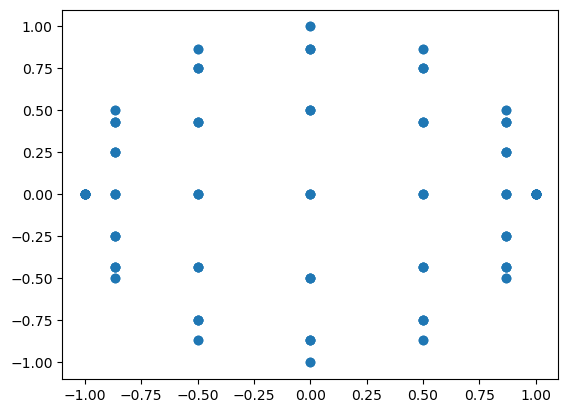

In [12]:
import matplotlib.pyplot as plt
plt.scatter(s[:,:,2],s[:,:,1])

In [8]:
a = torch.arange(0,1,step=1/6)

In [9]:
import torch

In [12]:
help(torch.concat)

Help on built-in function concat in module torch:

concat(...)
    concat(tensors, dim=0, *, out=None) -> Tensor
    
    Alias of :func:`torch.cat`.



In [11]:
help(torch.broadcast_to)

Help on built-in function broadcast_to in module torch:

broadcast_to(...)
    broadcast_to(input, shape) -> Tensor
    
    Broadcasts :attr:`input` to the shape :attr:`\shape`.
    Equivalent to calling ``input.expand(shape)``. See :meth:`~Tensor.expand` for details.
    
    Args:
        input (Tensor): the input tensor.
        shape (list, tuple, or :class:`torch.Size`): the new shape.
    
    Example::
    
        >>> x = torch.tensor([1, 2, 3])
        >>> torch.broadcast_to(x, (3, 3))
        tensor([[1, 2, 3],
                [1, 2, 3],
                [1, 2, 3]])



In [17]:
a

tensor([0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333])

In [20]:
a.unsqueeze(-1)

tensor([[0.0000],
        [0.1667],
        [0.3333],
        [0.5000],
        [0.6667],
        [0.8333]])

In [6]:
import builtins


class MyApp(ContextShowBase):
    def __init__(self):
        super().__init__()

        # cube = create_cube()
        sphere = create_sphere_node("01",12,12)
        self.render.attachNewNode(sphere)

        # Set the camera position
        # https://docs.panda3d.org/1.10/python/introduction/tutorial/controlling-the-camera
        self.taskMgr.add(self.spin_camera_task, "SpinCameraTask")

    def spin_camera_task(self, task):
        angleDegrees = task.time * 60.0
        angleRadians = angleDegrees * (pi / 180.0)
        self.camera.setPos(20 * sin(angleRadians), -20 * cos(angleRadians), 3)
        self.camera.setHpr(angleDegrees, 0, 0)

        return Task.cont
    

# class AppWrapper:
#     def __init__(self, appClass):
#         self.appClass = appClass
#     def __enter__(self):
#         self.app = appClass()
    
#     def run(self, *args, **kwargs):
#         self.app.run(*args, **kwargs)
        
#     def __exit__(self, *args):
#         self.app.destroy()

try:
    with MyApp() as app:
        app.run()
except Exception as e:
    print(e)
finally:
    if hasattr(builtins, 'base'):
        builtins.base.destroy()

name 'create_sphere_node' is not defined


Known pipe types:
  glxGraphicsPipe
(all display modules loaded.)
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager


In [ ]:
ShowBase.

In [2]:
class Cls:
    def __enter__(self):
        return self
    def __exit__(self,*args):
        print("exit")
with Cls() as s:
    print(s)

exit


In [9]:
import datetime
print("{}".format(datetime.datetime.now()))

2024-08-21 23:05:08.025825
